In [87]:
# from google.colab import files

# # Prompt the user to upload files
# uploaded = files.upload()

# # Process each uploaded file
# for file_name, file_content in uploaded.items():
#     # Save the file to disk
#     with open(file_name, 'wb') as f:
#         f.write(file_content)

#     # Extract the zip file if needed
#     if file_name.endswith('.zip'):
#         import zipfile
#         with zipfile.ZipFile(file_name, 'r') as zip_ref:
#             zip_ref.extractall()

# # tooks 3hrs 50 min to compelete

# 🐶 End-to-end Multiclass Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow hub.

## 1.0 Problem

Identifying the breed of dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of dog, I want to know what breed of dog it is.

## 2.0 Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/competitions/dog-breed-identification/data

## 3.0 Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4.0 Features

Some informations about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfrt learning.
* There are 120 breeds of dogs (this means there are 120 differeny classes).
* There are arounf 10,000+ images i the training set (these images have labels)
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).


### Get our workspace ready

* Import TensorFlow 2.x ✅
* Import TensorFlow Hub
* Make sure we're using a GPU

In [88]:
# import neccesary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "availble(YES!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.13.0
TF Hub version: 0.14.0
GPU availble(YES!!!)


## Getting our data ready (turning into tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors

Let's start by accessing our data and checking out the labels

In [89]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/labels.csv")
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [90]:
# How many images are there of each bread
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

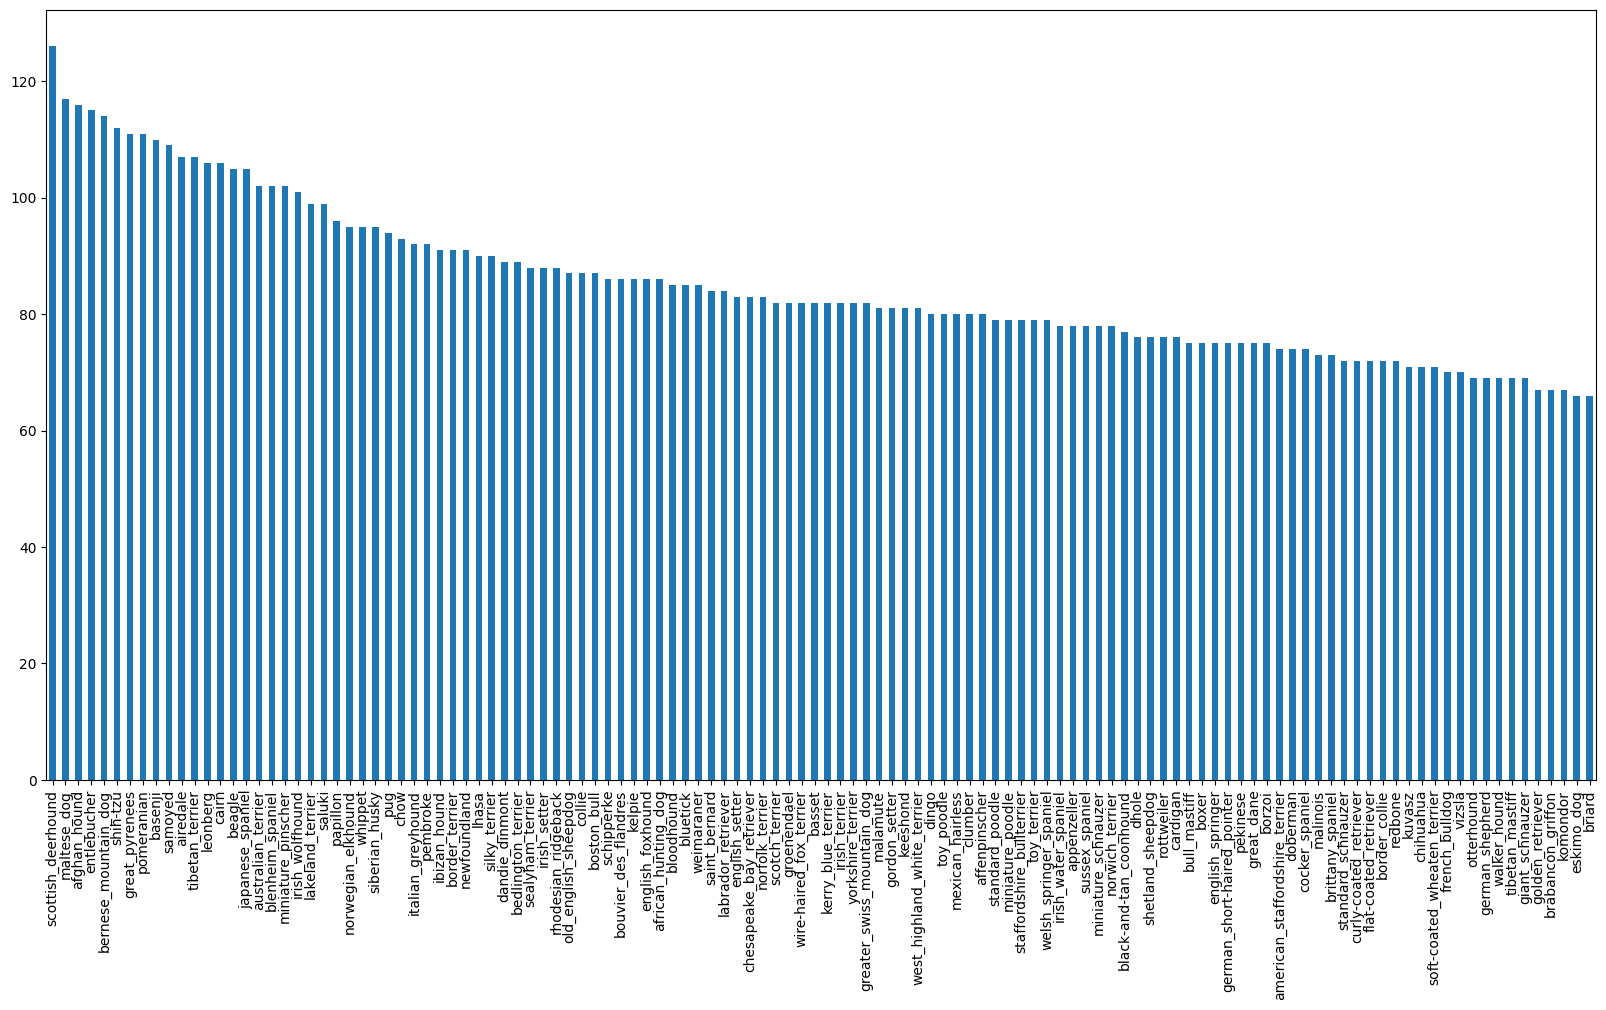

In [91]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

In [92]:
labels_csv["breed"].value_counts().median()

82.0

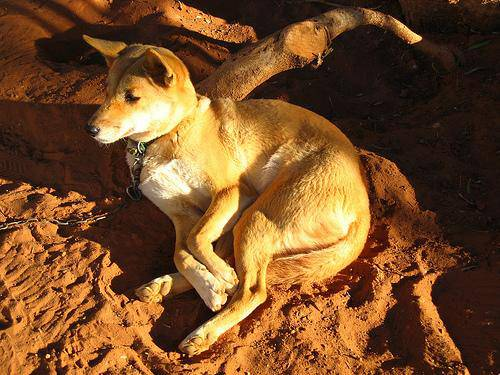

In [93]:
# Let's  view an image
from IPython.display import Image
Image("/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of all of our image file pathnames

In [94]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [95]:
# Create pathnames from image ID's
filenames = [f"/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/train/{fname}.jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 

In [96]:
# check whether number of filenames matches number of actual image files
import os

if len(os.listdir("/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/train")) == len(filenames):
    print("Filenames match actual amount of files!!! Proceed.")
else:
    print("Filnames do not match actual amount of files, check the target dir")

Filenames match actual amount of files!!! Proceed.


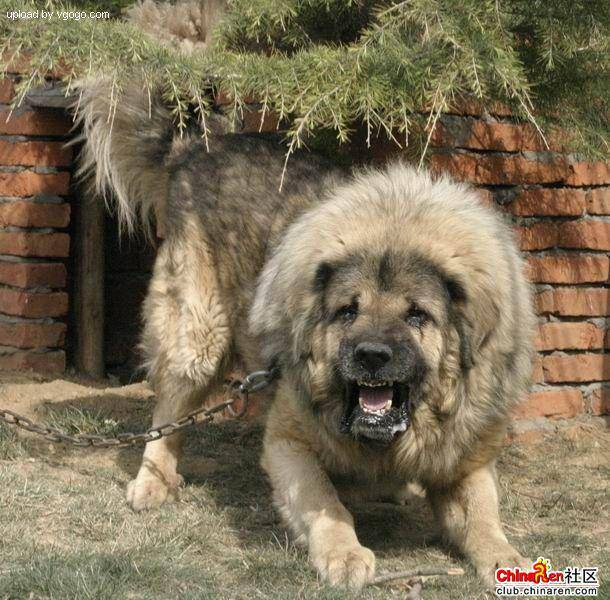

In [97]:
Image(filenames[9000])

In [98]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training images filepaths in a list, let's prepare our labels

In [99]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [100]:
len(labels)

10222

In [101]:
# see if number of labels matches the number of filenames
if len(labels) == len(filenames):
    print("Number of labels matches number of filenames!")
else:
    print("Number of labels does not match number of filenames, check data directories")

Number of labels matches number of filenames!


In [102]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [103]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [104]:
# Turn every label into boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [105]:
len(boolean_labels)

10222

In [106]:
# Example: Turning boolean array into integers
print(labels[0])
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where labels occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [107]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [108]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our won.

In [109]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [110]:
len(filenames)

10222

We're going to start off experimenting with ~ 100 images and increase as needed.

In [111]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: "slider", min: 1000, max: 10000, step: 1000}

In [112]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(
    X[:NUM_IMAGES],
    y[:NUM_IMAGES],
    test_size=0.2,
    random_state=42
)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [113]:
# Let's have a geeze at the training data
X_train[:5], y_train[:2]

(['/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
       

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`

Before we do, let;s see what importing an image looks like

In [114]:
# Convert image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [115]:
image.max(), image.min()

(255, 0)

In [116]:
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  5

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our `image` (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

In [117]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
    """
    Take an image file path and turns the image into a Tensor
    """
    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensors with 3 color channels (Red
    # Green, Blue)
    image = tf.image.decode_jpeg(image, channels=3)
    # convert the color channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired value (224, 224)
    image = tf.image.resize(image, size=[img_size, img_size])

    return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we so about 32 (this is batch size) images at a time (you can mannually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which looks like this
`(image, label)`

In [118]:
# Creae a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Take an image file path name and the associate label,
    process the image and returns a tuple of (image, label).
    """
    return process_image(image_path), label

Now we've got a way to turn our data into tuples of Tensors
in the form : `(image, label)`, let's make a function to turn all of our data (`X` and `y`) into batches

In [119]:
# Define the batch size 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Create batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if
    it's validation data.
    Also accepts test data as input (no labels).
    """
    # if the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths no labels
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch

    # if the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Create validation data batches....")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepath
                                                   tf.constant(y))) # labels
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

    # Turn filepaths and labels into Tensors
    else:
        print("Creating training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))

        # Shuffling pathnames and labels before mapping image processor function is faster than suffling images
        data = data.shuffle(buffer_size=len(X))

        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the training data into batches
        data_batch = data.batch(batch_size)
        return data_batch



In [120]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Create validation data batches....


In [121]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [122]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them

In [123]:
import matplotlib.pyplot as plt

# create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch
    """
    # setup the figure
    plt.figure(figsize=(10, 10))
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i + 1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn the grid lines off
        plt.axis("off")



In [124]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [125]:
train_images, train_labels = next(train_data.as_numpy_iterator())

In [126]:
len(train_images), len(train_labels)

(32, 32)

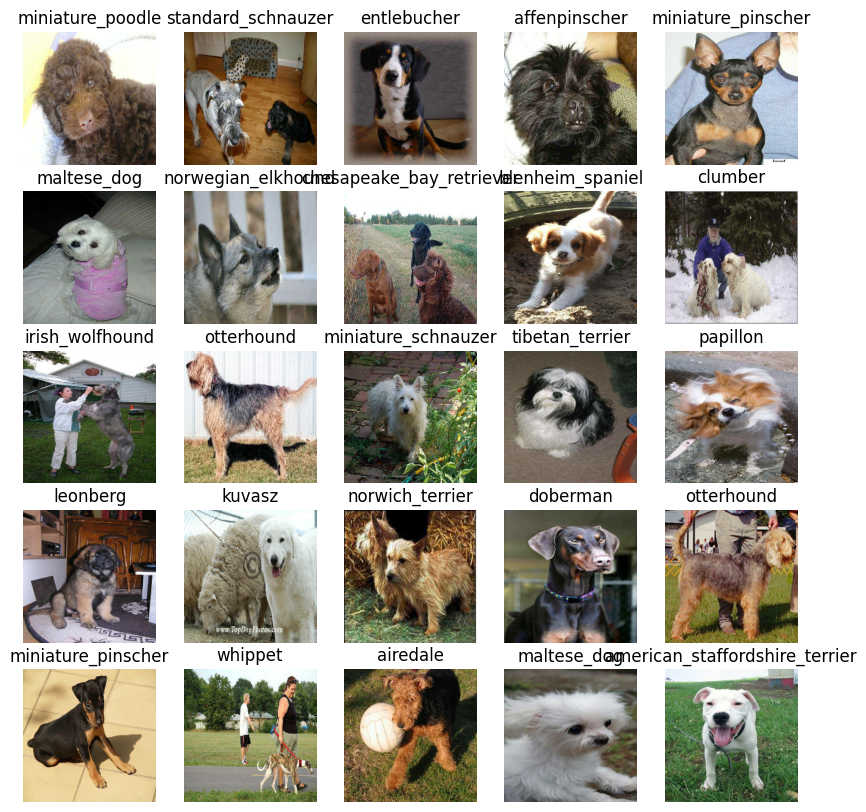

In [127]:
# Now let's visualize the data in a training batch

show_25_images(train_images, train_labels)

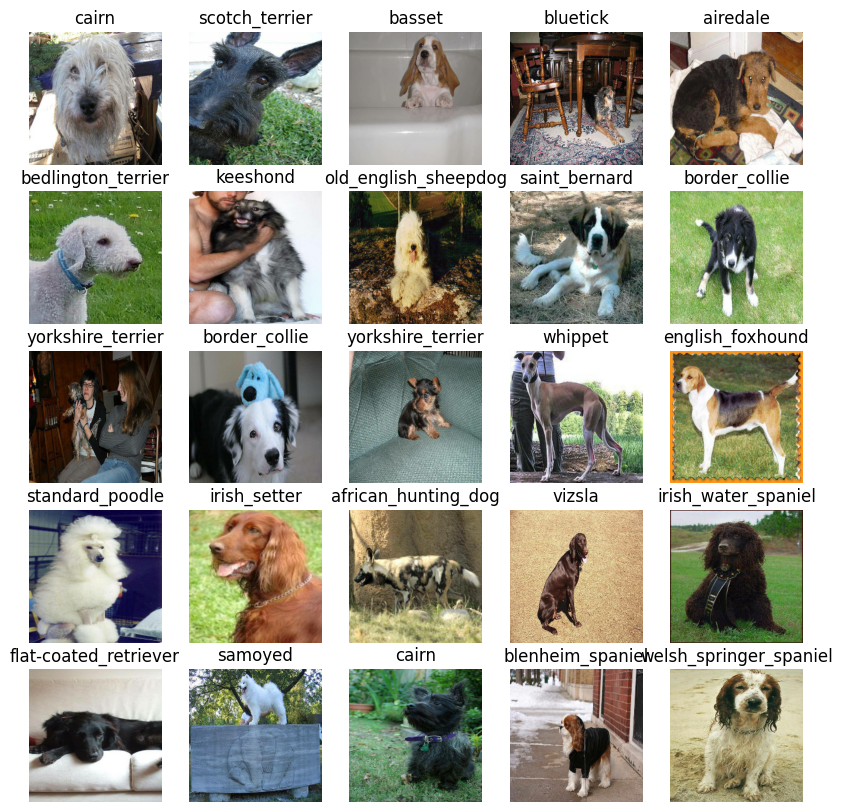

In [128]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:

* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model
* The URL of the model we wan to use from Tensorflow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5.

In [129]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = (len(unique_breeds))

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we've got our inputs, outputs and model ready to go.
Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosed as parameters
* Define the layers in a Keras model in sequential fashion (do this first, then this, then that)
* Compiles the model (says how it should be evaluated and improved)
* Build the model (tells the model the input shape it'll be getting)
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras

In [130]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    """
    Create a model
    """
    print("Building model with:", model_url)

    # setup the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url), # layer 1 (input layer)
        tf.keras.layers.Dense(units=output_shape, activation="softmax") # layer 2 (output layer)
    ])

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    # Build the model
    model.build(input_shape)

    return model

In [131]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_3 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Create callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension ✅
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function. ✅
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after nodel training)

In [132]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [133]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # create a log directory
    os.makedirs("/content/logs", exist_ok=True)
    logdir = os.path.join(
        "/content/logs",
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    )
    return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a evaluation metrics stops improving

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [134]:
# Create early stopping callback
early_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [135]:
NUM_EPOCHS = 100 #@param {type: "slider", min: 10, max: 100, step: 10}

Let's create a function which trains a model.
* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number od epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [136]:
# Build a function to train and return a trained model
def train_model():
    """
    Trains a given model and returns the trained version.
    """

    # create a model
    model = create_model()

    # create a new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()

    # Fit the model
    model.fit(x=train_data,
              epochs=NUM_EPOCHS,
              validation_data=val_data,
              validation_freq=1,
              callbacks=[tensorboard, early_callback])

    return model

In [137]:
# Fit the model to tge data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 14s 408ms/step - loss: 4.5985 - accuracy: 0.0962 - val_loss: 3.4650 - val_accuracy: 0.2000
Epoch 2/100
25/25 [==============================] - 4s 150ms/step - loss: 1.6274 - accuracy: 0.7025 - val_loss: 2.1605 - val_accuracy: 0.4500
Epoch 3/100
25/25 [==============================] - 3s 120ms/step - loss: 0.5539 - accuracy: 0.9425 - val_loss: 1.6765 - val_accuracy: 0.5950
Epoch 4/100
25/25 [==============================] - 3s 125ms/step - loss: 0.2478 - accuracy: 0.9862 - val_loss: 1.4792 - val_accuracy: 0.5950
Epoch 5/100
25/25 [==============================] - 4s 172ms/step - loss: 0.1474 - accuracy: 0.9962 - val_loss: 1.4042 - val_accuracy: 0.6200
Epoch 6/100
25/25 [==============================] - 4s 141ms/step - loss: 0.0992 - accuracy: 0.9987 - val_loss: 1.3589 - val_accuracy: 0.6150
Epoch 7/100
25/25 [=============================

**Question** It looks like our model is overfitting because it's performing far better on the training data set than the validation data set, what are some ways to prevent model overfitting in deep learning neural networks?

**Note** Overfitting to begin with is a good things! It means our model is learning!

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we create earlier and visualize its contents.

In [138]:
!kill 10218

/bin/bash: line 1: kill: (10218) - No such process


In [139]:
%tensorboard --logdir /content/logs

Reusing TensorBoard on port 6006 (pid 33213), started 0:59:50 ago. (Use '!kill 33213' to kill it.)

<IPython.core.display.Javascript object>

## Making and evaluating predictions using a trained model

In [140]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [141]:
# Make prediction on the validation data (not used to train on)
predictions = model.predict(val_data, verbose="auto")
predictions

7/7 [==============================] - 1s 80ms/step


array([[4.4747014e-03, 4.2768050e-05, 9.6622482e-04, ..., 6.1523530e-04,
        6.7433059e-05, 4.8900913e-03],
       [3.1036530e-03, 1.1100827e-03, 2.8676558e-03, ..., 4.1206382e-04,
        9.6844975e-04, 4.6085202e-05],
       [8.8344377e-06, 3.4506927e-04, 6.2256368e-05, ..., 1.9523122e-05,
        8.5963205e-05, 8.2607748e-04],
       ...,
       [1.3504476e-05, 3.5540048e-05, 1.8386969e-04, ..., 2.0261004e-05,
        4.4893322e-04, 7.5621851e-05],
       [1.3422122e-03, 6.0161317e-05, 6.5143322e-05, ..., 9.0434791e-05,
        3.1957134e-05, 6.3760574e-03],
       [2.2100345e-03, 3.3743927e-06, 3.3281106e-03, ..., 1.2669546e-03,
        9.8710752e-04, 8.1122322e-05]], dtype=float32)

In [142]:
np.sum(predictions[0])

0.9999999

In [143]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predictied label: {unique_breeds[np.argmax(predictions[index])]}")

[2.39736146e-05 1.80097031e-05 1.43242578e-05 1.63454806e-05
 5.35889482e-03 4.49443105e-05 1.43954079e-04 4.86966252e-04
 1.13276457e-02 3.22854333e-02 3.03013567e-05 1.95434836e-06
 3.71514994e-04 6.01383811e-03 1.91808402e-04 5.32677397e-04
 3.83605629e-06 4.23056335e-04 3.01876134e-04 1.37978626e-04
 2.20826441e-05 6.08488452e-04 4.23848287e-05 8.44049555e-06
 3.70188360e-03 2.61443074e-05 9.43568466e-06 1.14008646e-04
 3.02585599e-04 8.55189210e-05 8.32499791e-05 1.62730721e-04
 5.43650458e-05 6.02394039e-06 2.27053170e-05 2.40909576e-05
 1.31139692e-04 1.07172629e-04 2.95383998e-05 1.32994160e-01
 2.36104155e-04 3.90330115e-06 2.21916009e-03 7.42760039e-06
 1.68199898e-04 1.30710869e-05 3.54685879e-04 3.85893596e-04
 3.77039214e-05 2.36718290e-04 3.06646216e-05 2.07089070e-05
 7.45541620e-05 3.28200433e-04 9.63054572e-06 1.74779314e-04
 1.13680435e-04 2.33396950e-05 1.46488801e-05 6.18589593e-06
 4.21605582e-05 3.51037103e-04 2.11212091e-06 3.79349331e-05
 1.60308300e-05 3.148805

Having the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on

**Note:** Prediction probability are also known as confidence levels.

In [144]:
# Turn prediction probablities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turn an array of prediction probabilities into a label
    """

    return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

Now since our validation data is still in a batch dataset,
We'll have to unbatchify it to make prediction on the validation images and then compare those predictions to the validation labels (truth labels).

In [145]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
    """
    Takes a batched dataset of (image, label) Tensors and returns separate arrays
    of images and labels.
    """

    images = []
    labels = []

    # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels


# unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:
* prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make all a bit more visualize.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and integers. ✅
* Convert the prediction probabilities to a predicted label ✅
* Plot the predicted label, its predicted probability, the truth label and the target images on a single plot. ✅


In [146]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth and images for sample n
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    # Get the pred label
    pred_label = get_pred_label(pred_prob)

    # Plot image & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # change the color of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    # change plot title to be predicted probability and truth label
    plt.title("{} {:2.0f}% {}".format(
        pred_label,
        np.max(pred_prob)*100,
        true_label
        ), color=color)

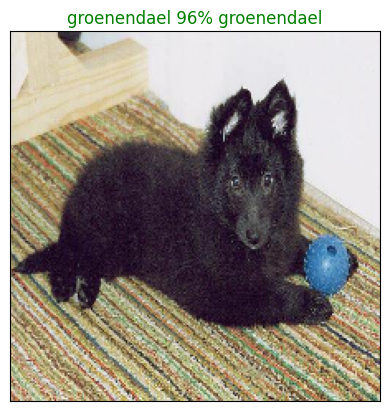

In [147]:
plot_pred(prediction_probabilities=predictions,
         labels=val_labels,
         images=val_images, n=77)

Now we've got sone function to visualize our models predictions, let's make another to view our models top 10 predictions

This function will:
* Take an imput of prediction probabilities array and a ground truth array and an integer ✅
* Find the prediction using `get_pred_label()` ✅
* Find the top 10:
  * Prediction probabilities indexes ✅
  * Prediction probabilities values ✅
  * Prediction labels ✅
* Plot the top 10 prediction probability values and labels, coloring the true label green ✅

In [148]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    """
    Plot the top 10 highest prediction confidences along with the truth label
    for sample n
    """
    pred_prob, true_label = prediction_probabilities[n], labels[n]

    # Get the prediction label
    pred_label = get_pred_label(pred_prob)

    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    # Find the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

    # setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                       top_10_pred_values,
                       color="gray")
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels=top_10_pred_labels,
               rotation="vertical")

    # change the color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    else:
        pass

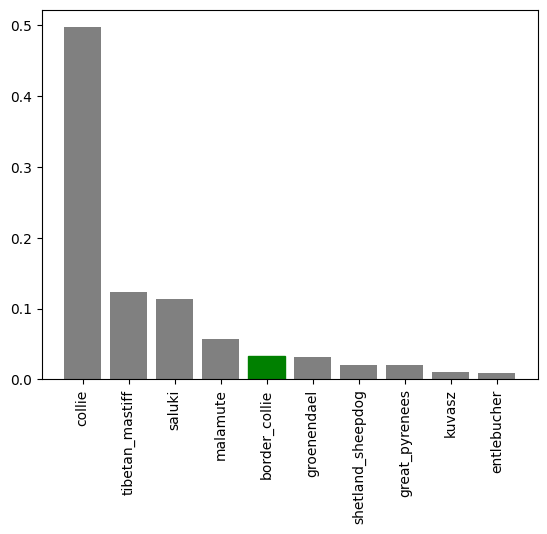

In [149]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we've got some functions to help us visualize our predictions and evaluate our model, let's check out a few

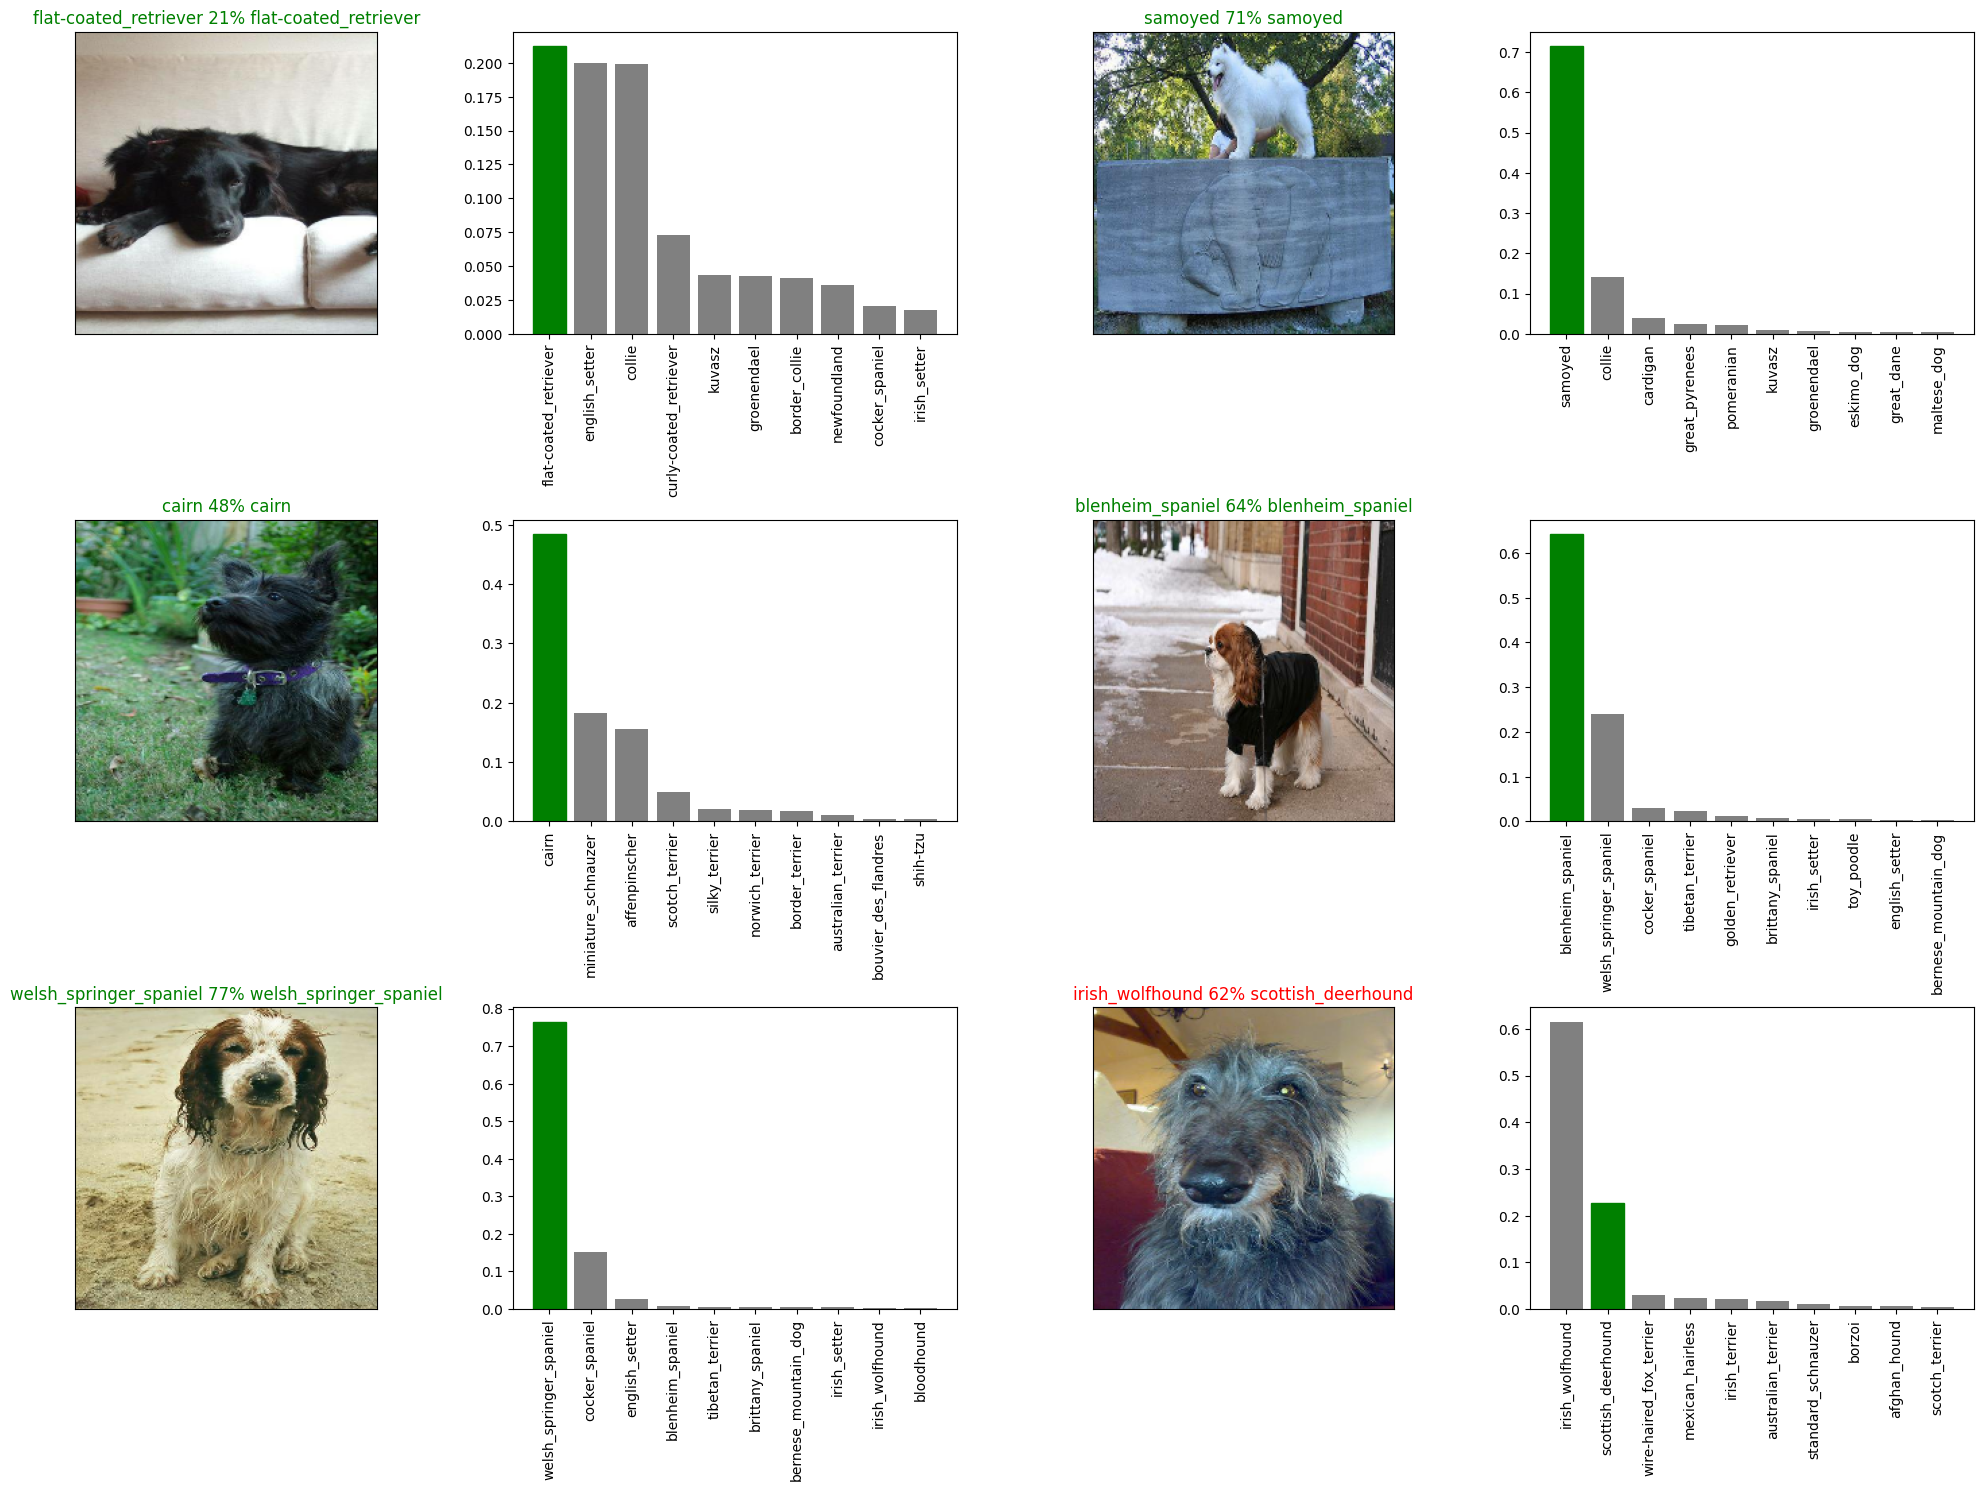

In [150]:
# Let's check out a few preidictions and their different values

i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5* num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probabilities=predictions,
              labels=val_labels,
              images=val_images,
              n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probabilities=predictions,
                   labels=val_labels,
                   n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

**Challenge:** How would your create a confusion matrix with our models predictions and true labels?

## Saving and reloading a trained model

In [151]:
# Create a function to save a model

def save_model(model, suffix=None):
    """
    Saves a given model in a models directory and append a suffix (string)
    """

    # create a model dir pathname with current time
    modeldir = os.path.join("/content/models", datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    model_path = modeldir + "-" + suffix + ".h5" #save format of model
    print(f"Saving model to: {model_path}...")
    model.save(model_path)
    return model_path


In [152]:
# Create a function to load a trained model

def load_model(model_path):
    """
    Loads a saved model from a specified path
    """
    print(f"Loading saved model from: {model_path}")
    model = tf.keras.models.load_model(model_path,
                                       custom_objects={"KerasLayer": hub.KerasLayer})
    return model

Now we've got functions to save and load a traineed model let's make sure they work!

In [153]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: /content/models/20231005-15301696519846-1000-images-mobilenetv2-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/models/20231005-15301696519846-1000-images-mobilenetv2-Adam.h5'

In [154]:
# Load a trained model
loaded_1000_image_model = load_model('/content/models/20231005-13421696513361-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: /content/models/20231005-13421696513361-1000-images-mobilenetv2-Adam.h5


In [155]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 72ms/step - loss: 1.2444 - accuracy: 0.6400


[1.2443753480911255, 0.6399999856948853]

In [156]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 78ms/step - loss: 1.2356 - accuracy: 0.6800


[1.2355923652648926, 0.6800000071525574]

## Training a big dog model 🐶 (on the full data)

In [157]:
len(X), len(y)

(10222, 10222)

In [158]:
# create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [159]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [160]:
# Create a model for ful model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [161]:
# Create full model callback
full_model_tensorboard = create_tensorboard_callback()
# No va;idation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note** Running the cell below will take a little while (maybe upto 30minutes for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [162]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 34s 95ms/step - loss: 1.3256 - accuracy: 0.6732
Epoch 2/100
320/320 [==============================] - 30s 94ms/step - loss: 0.4028 - accuracy: 0.8802
Epoch 3/100
320/320 [==============================] - 30s 94ms/step - loss: 0.2356 - accuracy: 0.9368
Epoch 4/100
320/320 [==============================] - 30s 94ms/step - loss: 0.1543 - accuracy: 0.9643
Epoch 5/100
320/320 [==============================] - 29s 91ms/step - loss: 0.1080 - accuracy: 0.9770
Epoch 6/100
320/320 [==============================] - 30s 94ms/step - loss: 0.0784 - accuracy: 0.9854
Epoch 7/100
320/320 [==============================] - 30s 94ms/step - loss: 0.0582 - accuracy: 0.9916
Epoch 8/100
320/320 [==============================] - 29s 91ms/step - loss: 0.0462 - accuracy: 0.9945
Epoch 9/100
320/320 [==============================] - 30s 92ms/step - loss: 0.0363 - accuracy: 0.9969
Epoch 10/100
320/320 [==============================] - 30s 93ms/step - l

In [163]:
# Save the full model
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: /content/models/20231005-15401696520433-full-image-set-mobilenetv2-Adam.h5...


'/content/models/20231005-15401696520433-full-image-set-mobilenetv2-Adam.h5'

In [170]:
# Load in the full model
loaded_full_model = load_model('/content/models/20231005-15401696520433-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: /content/models/20231005-15401696520433-full-image-set-mobilenetv2-Adam.h5


## Making prediction on the test datatest
Since our model has been trained on images on the form of Tensor batches, to make predictions on the test data, we'll have to get it into same format.

Luckily we create `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test images filenames ✅
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels). ✅
* Make a predictions array by passing the test batches to the `predict()` method called on our model. ✅


In [174]:
# Load test image filenames
test_path = "/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/e514f86170698394e20f0cd1af968451.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/e061b8d24e7b1324a6ac92ae81fdda19.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/e5507ebc0e05513bf543e160a484666f.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/e78b4a09e5f86c330e24c6aaed63f0be.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/e4b76574d24800b91bdcfc886fb74f23.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/e7dc8cc599049ea9fa2a172c88646c57.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/de5496c6b58f66ab890ab24087d9e220.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/dd7bf84df93991b7c15ec739c82acc04.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/dfc41d3f135d49a41e7b796883ff030e.jpg',
 '/content

In [175]:
len(test_filenames)

10357

In [176]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [177]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

**Note** Calling `predict()` on our full model and passing it the test batc will take a long time to run (about an ~ 1hr)

In [178]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data)

324/324 [==============================] - 197s 584ms/step


In [183]:
# # Save predictions (Numpy array) to csv file (for access later)
# np.savetxt("/content/preds_array.csv", test_predictions, delimiter=",")

In [180]:
# # Load predictions (NumPy array) from csv file
# test_predictions = np.loadtxt("/content/preds_array.csv", delimiter=",")

In [184]:
test_predictions[:10]

array([[7.8670830e-09, 1.9403705e-08, 2.2356178e-10, ..., 4.2333518e-08,
        5.0259336e-05, 1.1414091e-09],
       [4.5073034e-09, 4.6370438e-08, 9.2345189e-08, ..., 3.9326953e-10,
        5.1498027e-08, 1.4542014e-08],
       [2.1711521e-06, 1.9185263e-05, 1.0455555e-07, ..., 2.5297908e-08,
        1.2117281e-05, 8.4920134e-07],
       ...,
       [9.9987400e-01, 1.1090019e-11, 2.6300864e-10, ..., 1.8321912e-11,
        2.2756055e-08, 3.8257284e-08],
       [6.5707118e-10, 9.9095569e-06, 2.4758087e-10, ..., 7.3202259e-06,
        6.1912577e-09, 1.5713121e-09],
       [2.7636073e-09, 1.5149303e-12, 4.7205292e-11, ..., 2.4623611e-10,
        1.3720240e-11, 9.2596135e-09]], dtype=float32)

In [185]:
test_predictions.shape

(10357, 120)

## Preparing test dataset for Kaggle
Looking at tge Kaggle sample submission, we find that it wants our models prediction probability outputs in a dataframe with and ID and a column for each different dog breed.
www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as column for each dog breef
* Add data to the ID column by extraction the test image's ID from their filepaths
* Add data (the predictions probabilities) to each of the dog breed columns
* Export the DataFrame as a CSV to submit it to Kaggle

In [187]:
# Create a pandas DataFrame
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [191]:
# Append ID to test images ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [192]:
preds_df.head()

id affenpinscher afghan_hound  \
0  e514f86170698394e20f0cd1af968451           NaN          NaN   
1  e061b8d24e7b1324a6ac92ae81fdda19           NaN          NaN   
2  e5507ebc0e05513bf543e160a484666f           NaN          NaN   
3  e78b4a09e5f86c330e24c6aaed63f0be           NaN          NaN   
4  e4b76574d24800b91bdcfc886fb74f23           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [193]:
# Add the predictions probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  affenpinscher  afghan_hound  \
0  e514f86170698394e20f0cd1af968451   7.867083e-09  1.940371e-08   
1  e061b8d24e7b1324a6ac92ae81fdda19   4.507303e-09  4.637044e-08   
2  e5507ebc0e05513bf543e160a484666f   2.171152e-06  1.918526e-05   
3  e78b4a09e5f86c330e24c6aaed63f0be   1.186662e-05  2.737926e-08   
4  e4b76574d24800b91bdcfc886fb74f23   1.292803e-04  3.205909e-05   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         2.235618e-10  1.445638e-06                    3.398831e-08   
1         9.234519e-08  2.356240e-09                    3.137232e-09   
2         1.045556e-07  1.334652e-05                    4.964686e-08   
3         6.513883e-07  3.540325e-07                    2.727991e-03   
4         2.151139e-10  5.840797e-09                    1.590070e-11   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  1.288880e-06        5.193570e-05  1.521138e-06  3.738868e-04  ...   
1  5.505544e-08        7.775246e-09  5.760637e-07  1.923693e-10  ...   
2  3.970438e-10        1.458035e-10  9.187448e-08  6.647410e-09  ...   
3  1.193568e-04        6.163325e-10  3.822127e-05  3.804638e-07  ...   
4  5.850628e-06        3.272592e-09  1.850665e-08  2.117311e-08  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  2.882565e-08  2.213783e-07  4.660941e-07  3.653580e-01  5.173460e-09   
1  5.337884e-09  6.875823e-08  3.316876e-10  4.299094e-09  4.426632e-08   
2  9.165752e-06  4.972065e-09  4.979822e-08  8.168866e-08  1.594235e-09   
3  2.664446e-08  2.097131e-09  1.069802e-07  1.464920e-06  4.935129e-08   
4  1.357830e-05  9.251610e-09  2.747850e-11  1.200871e-10  6.731344e-11   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            5.940343e-06                 1.130317e-07  4.233352e-08   
1            1.927513e-09                 6.992388e-09  3.932695e-10   
2            8.847164e-09                 1.751555e-09  2.529791e-08   
3            4.424362e-08                 2.217769e-06  2.915936e-05   
4            7.832921e-13                 1.403976e-11  1.357502e-13   

   wire-haired_fox_terrier  yorkshire_terrier  
0             5.025934e-05       1.141409e-09  
1             5.149803e-08       1.454201e-08  
2             1.211728e-05       8.492013e-07  
3             2.812934e-08       6.783154e-09  
4             7.946020e-13       2.253042e-10  

[5 rows x 121 columns]

In [194]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("/content/model_prediction_submission_1_mobilenetv2.csv",
                index=False)

## Making prediction on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images
* Turn the filepath into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images

In [196]:
# !mkdir my-dog-photos
# !mv /content/jamie-street-6CcB5TDNqkQ-unsplash.jpg my-dog-photos/
# !mv /content/olga-andreyanova-XeOO8ir_YHs-unsplash.jpg my-dog-photos/
# !mv /content/sdf-rahbar-dw7paFI1jnM-unsplash.jpg my-dog-photos/

In [198]:
# Get the custom image filepaths

custom_path = "/content/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_image_paths


['/content/my-dog-photos/jamie-street-6CcB5TDNqkQ-unsplash.jpg',
 '/content/my-dog-photos/olga-andreyanova-XeOO8ir_YHs-unsplash.jpg',
 '/content/my-dog-photos/sdf-rahbar-dw7paFI1jnM-unsplash.jpg']

In [200]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [201]:
# Make prediction on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 2s 2s/step


In [202]:
custom_preds.shape

(3, 120)

In [203]:
# Get custom images prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['chesapeake_bay_retriever', 'golden_retriever', 'toy_poodle']

In [204]:
# Get the custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)

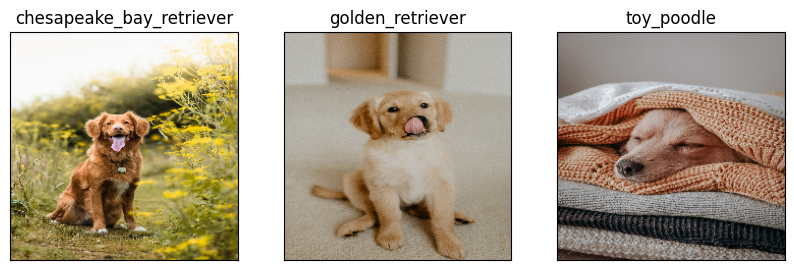

In [205]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
    plt.subplot(1, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_pred_labels[i])
    plt.imshow(image)